In [89]:
import os
import re
import numpy as np
import pandas as pd
import scipy as sp
import scipy.io as sio
import seaborn as sns
from tqdm import tqdm
from scipy import stats
import matplotlib.pyplot as plt
import pandas as pd
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)     # ignore warnings for specific matplotlib commands which will be outdated soon
warnings.simplefilter(action='ignore', category=FutureWarning)

In [90]:
def convert_to_code_path(windows_path):
    # Replace each single backslash with a double backslash
    return windows_path.replace("\\", "\\\\")

In [91]:
# def process_subfolders(main_folder, div, sheet_path, sheet_name='glass'):
#     """
#     Function to load CSVs from subfolders and match them with details from an Excel sheet.
#     Args:
#     - main_folder: Main directory path containing subfolders with CSV files.
#     - div: The 'div' value to filter the Excel sheet.
#     - sheet_path: Path to the Excel sheet containing imaging details.
#     - sheet_name: The sheet name in the Excel file (default: 'glass').

#     Returns:
#     - dataframes: A dictionary of loaded dataframes, keyed by subfolder names. 
#       Each key has two dataframes ('tp_trajectories_filtered' and 'track_properties').
#     - subfolder_names: A list of subfolder names that contain CSV files.
#     - frame_intervals: A list of frame intervals corresponding to the matched filenames.
#     - resolutions: A list of resolution values corresponding to the matched filenames.
#     - timepoints: A list of timepoints corresponding to the matched filenames.
#     """
    
#     # Load the Excel sheet and filter based on the 'div' value
#     df_sheet = pd.read_excel(sheet_path, sheet_name=sheet_name)
#     df_sheet_filtered = df_sheet[df_sheet['div'] == div]  # Filter based on 'div'
    
#     # Initialize containers
#     dataframes = {}
#     subfolder_names = []
#     frame_intervals = []
#     resolutions = []
#     timepoints = []  # New list to hold the number of timepoints
    
#     ind = 0  # Counter for successfully loaded subfolders
    
#     # Loop through each subfolder in the main directory
#     for subfolder in os.listdir(main_folder):
#         subfolder_path = os.path.join(main_folder, subfolder)
        
#         # Check if the path is a directory and contains both CSV files
#         if os.path.isdir(subfolder_path):
#             csv_file_traj = os.path.join(subfolder_path, 'tp_trajectories_filtered.csv')
#             csv_file_track = os.path.join(subfolder_path, 'track_properties.csv')
            
#             # Check for 'tp_trajectories_filtered.csv'
#             if os.path.isfile(csv_file_traj):
#                 df_traj = pd.read_csv(csv_file_traj)
#             else:
#                 df_traj = None  # Set to None if the file doesn't exist
            
#             # Check for 'track_properties.csv'
#             if os.path.isfile(csv_file_track):
#                 df_track = pd.read_csv(csv_file_track)
#             else:
#                 df_track = None  # Set to None if the file doesn't exist
            
#             # If at least one CSV exists, store it in the dictionary
#             if df_traj is not None or df_track is not None:
#                 dataframes[subfolder] = {
#                     'tp_trajectories_filtered': df_traj,
#                     'track_properties': df_track
#                 }
#                 subfolder_names.append(subfolder)
#                 ind += 1
    
#     print(f"{ind} subfolders have loaded successfully from {main_folder}.")

#     # Loop through subfolder names and match with Excel sheet details
#     for filename in subfolder_names:
#         for value in df_sheet_filtered['file name']:
#             if value in filename:
#                 # Extract frame interval
#                 index = df_sheet_filtered.index[df_sheet_filtered['file name'] == value].tolist()
#                 interval = df_sheet_filtered['frame interval'][index].values
#                 string_interval_value = interval[0]
#                 integer_interval_value = float(string_interval_value.split()[0])  # Extract numeric part
#                 frame_intervals.append(integer_interval_value)
                
#                 # Extract resolution
#                 resolution = df_sheet_filtered['resolution'][index].values
#                 string_resolution_value = resolution[0]
#                 if isinstance(string_resolution_value, float):
#                     resolutions.append(string_resolution_value)
#                 else:
#                     integer_resolution_value = float(string_resolution_value.split()[0])
#                     resolutions.append(integer_resolution_value)
                
#                 # Extract number of timepoints
#                 timepoint = df_sheet_filtered['# timepoints'][index].values
#                 timepoints.append(timepoint[0])  # Assuming you want the first value

#     print(f"{len(frame_intervals)} filenames matched with the imaging records for div={div}.")
    
#     return dataframes, subfolder_names, frame_intervals, resolutions, timepoints


In [92]:
def extract_numeric(value):
    """
    Extract numeric part from a string. Returns float if successful, else returns None.
    """
    if isinstance(value, (int, float)):
        return float(value)
    elif isinstance(value, str):
        # Use regex to extract numbers from the string
        match = re.search(r'[\d.]+', value)
        if match:
            return float(match.group(0))
    return None  # Return None if no numeric value is found

def process_subfolders(main_folder, div, sheet_path, sheet_name='glass', frame_interval_range=None, resolution_range=None):
    """
    Function to load CSVs from subfolders and match them with details from an Excel sheet.
    Args:
    - main_folder: Main directory path containing subfolders with CSV files.
    - div: The 'div' value to filter the Excel sheet.
    - sheet_path: Path to the Excel sheet containing imaging details.
    - sheet_name: The sheet name in the Excel file (default: 'glass').
    - resolution_range: Tuple (min_resolution, max_resolution) to filter by resolution.
    - frame_interval_range: Tuple (min_interval, max_interval) to filter by frame interval.

    Returns:
    - dataframes: A dictionary of loaded dataframes, keyed by subfolder names.
    - subfolder_names: A list of subfolder names that contain CSV files.
    - frame_intervals: A list of frame intervals.
    - resolutions: A list of resolution values.
    - timepoints: A list of timepoints.
    - neural_mask_paths: A list of paths to the 'neural_mask.mat' files.
    """
    
    df_sheet = pd.read_excel(sheet_path, sheet_name=sheet_name)
    df_sheet_filtered = df_sheet[df_sheet['div'] == div]  # Filter by 'div'
    
    # Initialize containers
    dataframes = {}
    subfolder_names = []
    frame_intervals = []
    resolutions = []
    timepoints = []
    neural_mask_paths = []

    skipped_folders = []
    ind = 0

    for subfolder in os.listdir(main_folder):
        subfolder_path = os.path.join(main_folder, subfolder)
        
        if os.path.isdir(subfolder_path):
            csv_file_traj = os.path.join(subfolder_path, 'tp_trajectories_filtered.csv')
            csv_file_track = os.path.join(subfolder_path, 'track_properties.csv')
            mat_file = os.path.join(subfolder_path, 'neural_mask.mat')
            
            if os.path.isfile(csv_file_traj) or os.path.isfile(csv_file_track):
                for value in df_sheet_filtered['file name']:
                    if value in subfolder:
                        index = df_sheet_filtered.index[df_sheet_filtered['file name'] == value].tolist()
                        
                        if index:
                            interval = df_sheet_filtered['frame interval'][index].values[0]
                            integer_interval_value = extract_numeric(interval)
                            resolution = df_sheet_filtered['resolution'][index].values[0]
                            integer_resolution_value = extract_numeric(resolution)
                            
                            if ((resolution_range is None or integer_resolution_value is None or (resolution_range[0] <= integer_resolution_value <= resolution_range[1])) and
                                (frame_interval_range is None or integer_interval_value is None or (frame_interval_range[0] <= integer_interval_value <= frame_interval_range[1]))):
                                
                                df_traj = pd.read_csv(csv_file_traj) if os.path.isfile(csv_file_traj) else None
                                df_track = pd.read_csv(csv_file_track) if os.path.isfile(csv_file_track) else None
                                
                                dataframes[subfolder] = {
                                    'tp_trajectories_filtered': df_traj,
                                    'track_properties': df_track
                                }
                                subfolder_names.append(subfolder)
                                frame_intervals.append(integer_interval_value)
                                resolutions.append(integer_resolution_value)
                                timepoints.append(df_sheet_filtered['# timepoints'][index].values[0])
                                neural_mask_paths.append(mat_file if os.path.isfile(mat_file) else None)
                                ind += 1
                                break
                            else:
                                skipped_folders.append({
                                    'folder': subfolder,
                                    'frame_interval': integer_interval_value,
                                    'resolution': integer_resolution_value
                                })
                                break
    
    print(f"{ind} subfolders loaded successfully.")
    print(f"{len(skipped_folders)} subfolders skipped:")
    for skipped in skipped_folders:
        print(f"Folder: {skipped['folder']}, Frame Interval: {skipped['frame_interval'] or 'None'}, Resolution: {skipped['resolution'] or 'None'}")

    return dataframes, subfolder_names, frame_intervals, resolutions, timepoints, neural_mask_paths


In [93]:
frame_interval = [1.8,2.2]
resolution = [2.6,2.9]

## DIV2 
main_folder = r'E:\Spandan\2D_Neurons_Paper\Glass\div2'   # Specify the main folder 
sheet_path = r'E:\Spandan\Kate\NEURON MOVIES\tifNotes.xlsx'  # Path to the Excel file
dataframes2, subfolder_names2, frame_intervals2, resolutions2, timepoints2, neural2 = process_subfolders(main_folder, div=2, sheet_path=sheet_path, frame_interval_range=frame_interval, resolution_range=resolution)


## DIV10
main_folder = r'E:\Spandan\2D_Neurons_Paper\Glass\div10'   
dataframes10, subfolder_names10, frame_intervals10, resolutions10, timepoints10, neural10 = process_subfolders(main_folder, div=10, sheet_path=sheet_path, frame_interval_range=frame_interval, resolution_range=resolution)


## DIV23
main_folder = r'E:\Spandan\2D_Neurons_Paper\Glass\div23'  
dataframes23, subfolder_names23, frame_intervals23, resolutions23, timepoints23, neural23 = process_subfolders(main_folder, div=23, sheet_path=sheet_path, frame_interval_range=frame_interval, resolution_range=resolution)

8 subfolders loaded successfully.
1 subfolders skipped:
Folder: control_div2_glass_2018_10_01_MAX_60X_B1_timelapse1, Frame Interval: 5.0, Resolution: 4.761904761904762
6 subfolders loaded successfully.
1 subfolders skipped:
Folder: control_div10_glass_2021_04_12_MAX_6well1_div10_timelapse3_100x, Frame Interval: 6.04272, Resolution: 7.1429
2 subfolders loaded successfully.
6 subfolders skipped:
Folder: control_div23_glass_2018_10_01_MAX_B4_timelapse1, Frame Interval: 5.0027, Resolution: 2.7778
Folder: control_div23_glass_2018_10_01_MAX_B4_timelapse2, Frame Interval: 5.0019, Resolution: 2.7778
Folder: control_div23_glass_2018_10_01_MAX_C4_timelapse1, Frame Interval: 5.13435, Resolution: 2.7778
Folder: control_div23_glass_2018_10_01_MAX_D4_timelapse1, Frame Interval: 5.0, Resolution: 2.7778
Folder: control_div23_glass_2018_10_01_MAX_D4_timelapse2, Frame Interval: 5.0, Resolution: 2.7778
Folder: control_div23_glass_2018_10_01_MAX_D4_timelapse3, Frame Interval: 5.0, Resolution: 2.7778


In [94]:
def calculate_metrics(subfolder_names, dataframes, frame_intervals, resolutions, timepoints, neural_mask_paths):
    """
    Calculate metrics for each subfolder based on trajectory and track properties.

    Args:
    - subfolder_names: List of subfolder names containing data.
    - dataframes: Dictionary of dataframes keyed by subfolder names.
    - frame_intervals: List of frame intervals corresponding to the subfolders.
    - resolutions: List of resolution values corresponding to the subfolders.
    - timepoints: List of timepoints corresponding to the subfolders.
    - neural_mask_paths: List of paths to the 'neural_mask.mat' files corresponding to the subfolders.

    Returns:
    - results_df: A pandas DataFrame containing calculated metrics.
    """
    
    # Initialize an empty dataframe to store the results
    results_df = pd.DataFrame(columns=['subfolder_name', 'duration_div', 'length_div', 'distance_div', 'n_tracks_norm', 'avg_vel_div'])

    # Loop over all movies (stored in different subfolders)
    for i in range(len(subfolder_names)):  
        subfolder_name = subfolder_names[i]  
        df_traj = dataframes[subfolder_name]['tp_trajectories_filtered']  # Access the trajectory dataframe
        df_track = dataframes[subfolder_name]['track_properties']  # Access the track properties dataframe

        # Access the specific value from the frame_intervals, resolutions, and timepoints lists
        frame_interval_for_subfolder = frame_intervals[i]  # Frame interval value (in seconds)
        resolution_for_subfolder = resolutions[i]  # Resolution value 
        timepoints_for_subfolder = timepoints[i]  # Number of timepoints

        # Load the neural_mask.mat file
        neural_mask_file = neural_mask_paths[i]  # Get the path for the corresponding neural_mask.mat
        neural_mask_data = sio.loadmat(neural_mask_file)  # Load the .mat file

        # Extract the mask value
        mask_value = neural_mask_data['neural_mask'] if 'neural_mask' in neural_mask_data else 1  # Default to 1 to avoid division by zero

        # Calculate the required metrics
        duration_div = np.nanmean(df_track['track_duration'] * frame_interval_for_subfolder)  # Duration in seconds
        distance_div = np.nanmean(df_track['distance'] / resolution_for_subfolder)  # Distance normalized by resolution
        length_div = np.nanmean(df_track['track_length'] / resolution_for_subfolder)  # Length normalized by resolution

        # Normalized number of tracks (tracks per minute)
        n_tracks_div = len(df_track['track_duration'])
        n_tracks_norm = 100 * (n_tracks_div / (timepoints_for_subfolder * frame_interval_for_subfolder / 60)) / np.nansum(mask_value) if timepoints_for_subfolder > 0 else 0
        
        avg_vel_div = np.nanmean(df_track['avg_velocity'] * 60 / (resolution_for_subfolder * frame_interval_for_subfolder))
        
        # Create a dictionary for the new row
        new_row = {
            'subfolder_name': subfolder_name,
            'duration_div': duration_div,
            'length_div': length_div,
            'distance_div': distance_div,  
            'n_tracks_norm': n_tracks_norm,  # Use normalized tracks
            'avg_vel_div': avg_vel_div,
        }

        # Remove any all-NA or empty values before concatenation
        clean_row = pd.DataFrame([new_row]).dropna(how='all')

        # Concatenate the new row to the dataframe
        if not clean_row.empty:
            results_df = pd.concat([results_df, clean_row], ignore_index=True)

    return results_df


In [95]:
# Define the necessary parameters for each DIV
# For DIV2
results_df_div2 = calculate_metrics(subfolder_names2, dataframes2, frame_intervals2, resolutions2, timepoints2, neural2)

# For DIV10
results_df_div10 = calculate_metrics(subfolder_names10, dataframes10, frame_intervals10, resolutions10, timepoints10, neural10)

# For DIV23
results_df_div23 = calculate_metrics(subfolder_names23, dataframes23, frame_intervals23, resolutions23, timepoints23, neural23)

# Optionally, save the resulting dataframes to CSV files
results_df_div2.to_csv(convert_to_code_path(r'E:\Spandan\2D_Neurons_Paper\Glass\results_summary_div2.csv'), index=False)
results_df_div10.to_csv(convert_to_code_path(r'E:\Spandan\2D_Neurons_Paper\Glass\results_summary_div10.csv'), index=False)
results_df_div23.to_csv(convert_to_code_path(r'E:\Spandan\2D_Neurons_Paper\Glass\results_summary_div23.csv'), index=False)


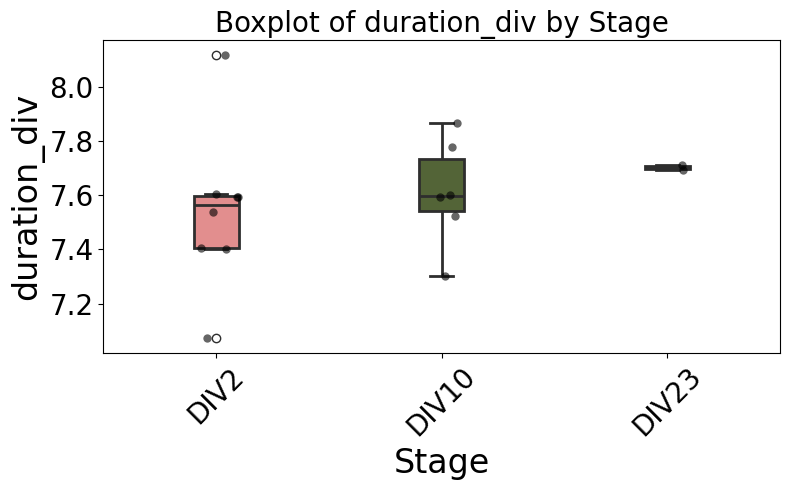

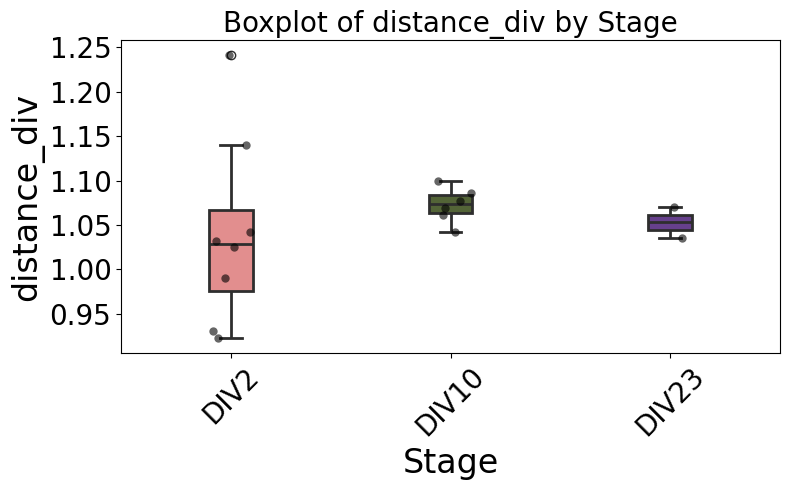

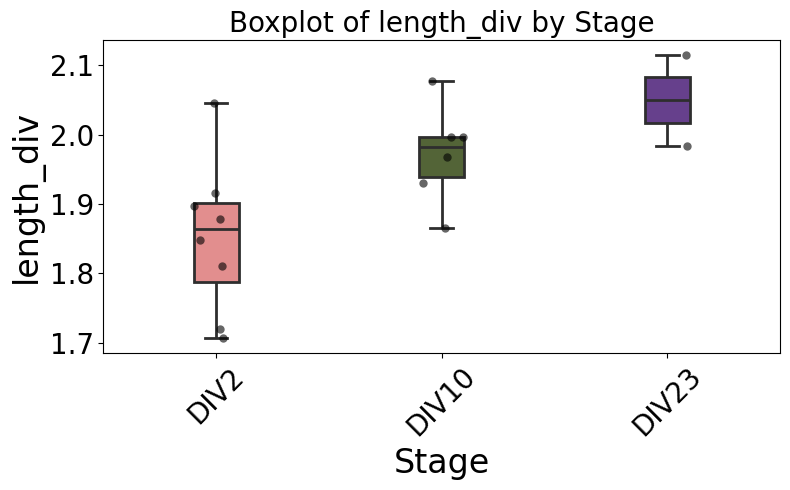

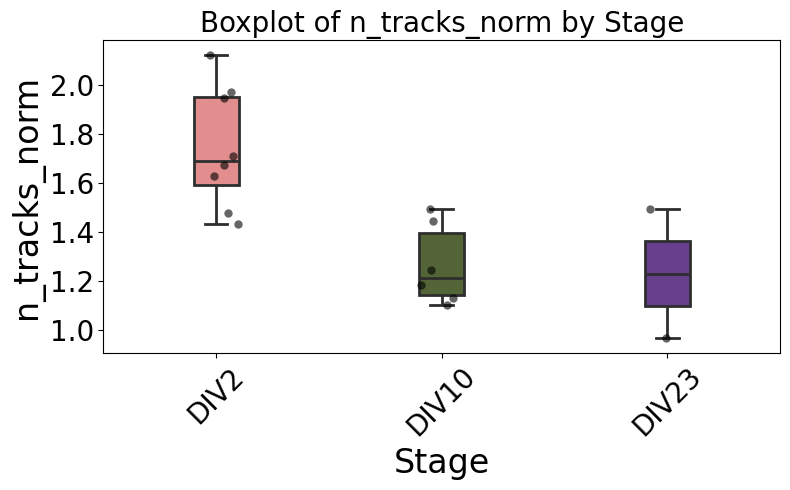

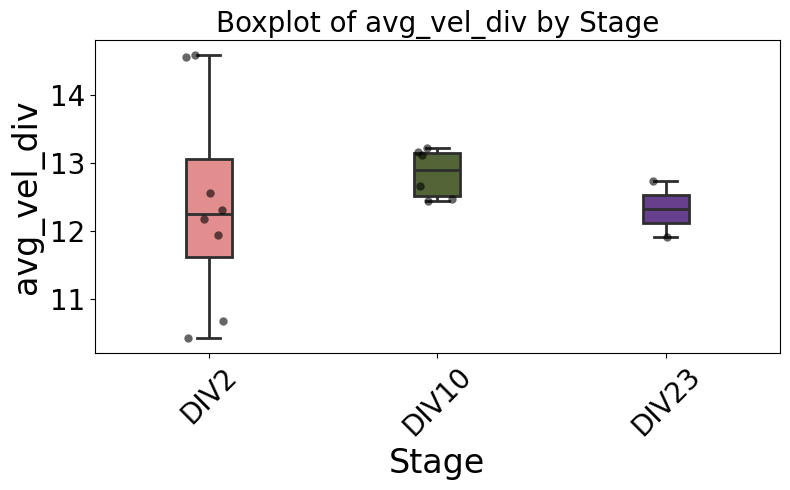

In [100]:
# Load results dataframes (adjust the paths as necessary)
results_df_div2 = pd.read_csv(convert_to_code_path(r'E:\Spandan\2D_Neurons_Paper\Glass\results_summary_div2.csv'))
results_df_div10 = pd.read_csv(convert_to_code_path(r'E:\Spandan\2D_Neurons_Paper\Glass\results_summary_div10.csv'))
results_df_div23 = pd.read_csv(convert_to_code_path(r'E:\Spandan\2D_Neurons_Paper\Glass\results_summary_div23.csv'))

# Combine the results into a single DataFrame for plotting
results_combined = pd.concat([
    results_df_div2.assign(DIV='DIV2'),
    results_df_div10.assign(DIV='DIV10'),
    results_df_div23.assign(DIV='DIV23')
])

# List of metrics to plot
metrics = ['duration_div', 'distance_div', 'length_div', 'n_tracks_norm', 'avg_vel_div']
results_ttests = {}

# Define colors for each DIV
div_colors = {
    'DIV2': 'lightcoral',
    'DIV10': 'darkolivegreen',
    'DIV23': 'rebeccapurple'
}

# Create separate figures for each metric
for metric in metrics:
    plt.figure(figsize=(8, 5))
    
    # Create boxplot with narrower boxes and bolder outlines
    sns.boxplot(data=results_combined, x='DIV', y=metric, width=0.2,  # Narrower width
                palette=div_colors, linewidth=2)

    # Overlay scatter points with increased size
    sns.stripplot(data=results_combined, x='DIV', y=metric, color='black', 
                  alpha=0.6, size=6)

    # Customize the plot
    plt.title(f'Boxplot of {metric} by Stage', fontsize=20)
    plt.xlabel('Stage', fontsize=24)
    plt.ylabel(metric, fontsize=24)
    plt.xticks(rotation=45, fontsize=20)
    plt.yticks(fontsize=20)
    plt.tight_layout()

    # Save the figure as an SVG file with high DPI
    plt.savefig(f'{metric}_boxplot.svg', dpi=300)
    plt.show()

    # Perform t-tests between DIV groups for the current metric
    div2_values = results_df_div2[metric].dropna()
    div10_values = results_df_div10[metric].dropna()
    div23_values = results_df_div23[metric].dropna()

    ttest_results = {
        'DIV2 vs DIV10': stats.ttest_ind(div2_values, div10_values, equal_var=False),
        'DIV2 vs DIV23': stats.ttest_ind(div2_values, div23_values, equal_var=False),
        'DIV10 vs DIV23': stats.ttest_ind(div10_values, div23_values, equal_var=False)
    }
    
    results_ttests[metric] = ttest_results


In [98]:
# Print the t-test results
for metric, ttest in results_ttests.items():
    print(f"\nT-test results for {metric}:")
    for comparison, result in ttest.items():
        print(f"{comparison}: t-statistic = {result.statistic:.4f}, p-value = {result.pvalue:.4f}")


T-test results for duration_div:
DIV2 vs DIV10: t-statistic = -0.5321, p-value = 0.6044
DIV2 vs DIV23: t-statistic = -1.5497, p-value = 0.1645
DIV10 vs DIV23: t-statistic = -1.1231, p-value = 0.3111

T-test results for distance_div:
DIV2 vs DIV10: t-statistic = -0.8351, p-value = 0.4290
DIV2 vs DIV23: t-statistic = -0.2970, p-value = 0.7741
DIV10 vs DIV23: t-statistic = 1.0576, p-value = 0.4317

T-test results for length_div:
DIV2 vs DIV10: t-statistic = -2.4497, p-value = 0.0308
DIV2 vs DIV23: t-statistic = -2.5757, p-value = 0.1374
DIV10 vs DIV23: t-statistic = -1.0761, p-value = 0.4308

T-test results for n_tracks_norm:
DIV2 vs DIV10: t-statistic = 4.3501, p-value = 0.0010
DIV2 vs DIV23: t-statistic = 1.8479, p-value = 0.2789
DIV10 vs DIV23: t-statistic = 0.1321, p-value = 0.9144

T-test results for avg_vel_div:
DIV2 vs DIV10: t-statistic = -0.7802, p-value = 0.4577
DIV2 vs DIV23: t-statistic = 0.1095, p-value = 0.9168
DIV10 vs DIV23: t-statistic = 1.1816, p-value = 0.4127
